## Data Preperation

In this section, we load in the data and do some preprocessing. Specifically, we convert the images into grayscale and resize them to 300 by 400 pixels each. We also get labels for each image; the label is the name of the dog breed associated with each picture. We use the first 1000 images in our dataset for analysis. We limit the sample size to only 1000 because of runtime and memory constraints.

In [5]:
#Imports
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import os
import os.path
import random


#Set the image size and path to the data
img_size = (300,400)
#img_path = 'Images/'
img_path = '/mnt/c/Users/Tylergiallanza/Downloads/dogs/Images/'
img_paths = []
img_annotations = []

#The images are stored in subdirectories - go through all of them
for dirpath, dirnames, filenames in os.walk(img_path):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        img_paths.append(os.path.join(dirpath, filename))
        img_annotations.append(dirpath.split('/')[-1].split('-')[1])

['/mnt/c/Users/Tylergiallanza/Downloads/dogs/Images/n02116738-African_hunting_dog/n02116738_9798.jpg', '/mnt/c/Users/Tylergiallanza/Downloads/dogs/Images/n02116738-African_hunting_dog/n02116738_9818.jpg', '/mnt/c/Users/Tylergiallanza/Downloads/dogs/Images/n02116738-African_hunting_dog/n02116738_9829.jpg', '/mnt/c/Users/Tylergiallanza/Downloads/dogs/Images/n02116738-African_hunting_dog/n02116738_9844.jpg']
['African_hunting_dog', 'African_hunting_dog', 'African_hunting_dog', 'African_hunting_dog']


In [ ]:
img_data = []
for path in img_paths[0:1000]:
    img_data.append(color.rgb2grey(resize(plt.imread(path).astype(np.uint8),img_size)).flatten())
img_annotations = img_annotations[0:1000]

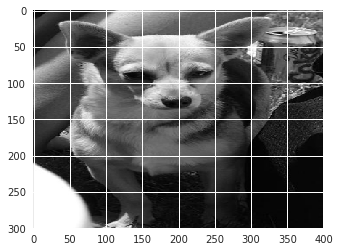

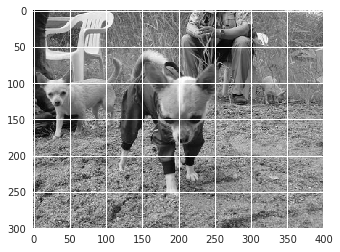

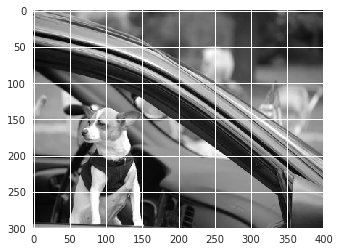

In [72]:
plt.imshow(img_data[0].reshape(img_size),cmap='gray')
plt.show()
plt.imshow(img_data[10].reshape(img_size),cmap='gray')
plt.show()
plt.imshow(img_data[30].reshape(img_size),cmap='gray')
plt.show()

## DAISY Feature Extraction
We decided to do a DAISY feature extraction to test how well it would perform in the classification task we had at hand. The following cells show how it was applied on the first image in our dataset that we worked with, with the important note that we selected a bigger step to better visualize the descriptor.

### Visualizing DAISY

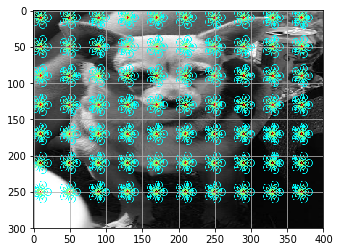

In [7]:
from skimage.feature import daisy
%matplotlib inline
img = img_data[0].reshape(img_size)
# visualize daisy descriptor
features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
plt.imshow(img_desc)
plt.grid()

The cell above visualizes the DAISY classifier on top of the first image in the dataset.

Below is the original image:

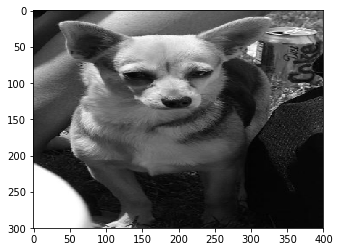

In [9]:
plt.imshow(img,cmap='gray')

### Feature Extraction with DAISY

We estimated how many features would be extracted with the settings that were applied and ran the DAISY descriptor on all images in our dataset.

In [11]:
features = daisy(img,step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(28, 38, 104)
110656


We then extract the daisy features for each image, storing each feature vector.

In [12]:
# create a function to take in the row of the matrix and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(img_data[0],img_size)
test_feature.shape

CPU times: user 344 ms, sys: 109 ms, total: 453 ms
Wall time: 459 ms


(110656,)

In [13]:
# apply to entire data, row by row
#takes about 4 minutes to run on dataset of size 1000
%time daisy_features = np.apply_along_axis(apply_daisy, 1, img_data, img_size)
print(daisy_features.shape)

CPU times: user 5min 30s, sys: 1min 49s, total: 7min 19s
Wall time: 7min 28s
(1000, 110656)


### Nearest Neighbor Classifier with DAISY

Next, we used the DAISY features to classify some of our images. We calculated the pairwise differences in the features for each image, then we found the image nearest to each image.

In [14]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 44.7 s, sys: 1.19 s, total: 45.9 s
Wall time: 12 s


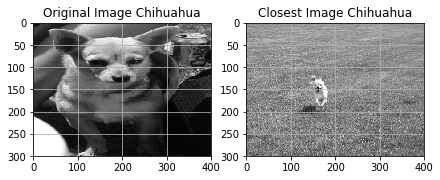

In [15]:
import copy
# find closest image to current image
idx1 = 0
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
plt.imshow(img_data[idx1].reshape(img_size),cmap="gray")
plt.title("Original Image " + img_annotations[idx1])
plt.grid()

plt.subplot(1,2,2)
plt.imshow(img_data[idx2].reshape(img_size),cmap="gray")
plt.title("Closest Image " + img_annotations[idx2])
Aplt.grid()

The images above visualize finding the nearest neighbor for the first image in the dataset. The original image is of class Chihuahua, and the nearest neighbor is of class Chihuahua. Therefore, the classifier correctly classified the first image in the data set based on the DAISY descriptors.

Next, we run the nearest neighbor classifier for all of the images in the dataset.

In [55]:
correctly_classified = 0
incorrectly_classified = 0

for idx1 in range(0,len(img_annotations)):
    distances = copy.deepcopy(dist_matrix[idx1,:])
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    predicted_class = img_annotations[idx1]
    true_class = img_annotations[idx2]
    if true_class == predicted_class:
        correctly_classified += 1
    else:
        incorrectly_classified += 1

print('Correctly classified by nearest neighbor:',correctly_classified/(correctly_classified+incorrectly_classified)*100,'%')
print('Number of classes:',len(set(img_annotations)))
print('Random classifier:',1/len(set(img_annotations)),'%')

Correctly classified by nearest neighbor: 16.400000000000002 %
Number of classes: 6
Random classifier: 0.16666666666666666 %


Based on the results of the nearest neighbor classifier, only 16.4% of images were classified correctly. This shows that the DAISY features in and of themselves are not sufficient to classify the images. Since there are only 6 classes in our dataset, randomly guessing the class of a given image yeilds a 16.67% chance of correctly classiying the image. Thus, the DAISY features are actually worse than random at classifying the images. 

Since our business sponsors would probably not be happy paying us to do machine learning if our results are worse than rolling a die, it is safe to say that DAISY does not show promise for the task of classifying our images.

## Histogram of Oriented Gradients

Next, we used the DAISY features to classify some of our images. We calculated the pairwise differences in the features for each image, then we found the image nearest to each image.

For the additional analysis, we use HOG (Histogram of Oriented Gradients) to classify the images instead of DAISY. We follow the same procedure as we did with DAISY - find the pairwise distances and use a nearest neighbor classifier to figure out the accuracy.

In [63]:
from skimage.feature import hog
hog_features = hog(img)
print(hog_features.shape)

(136080,)


/home/tylergiallanza/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [67]:
# create a function to take in the row of the matrix and return a new feature
def apply_hog(row,shape):
    feat = hog(row.reshape(shape))
    return feat.reshape((-1))

%time hog_features = np.apply_along_axis(apply_hog, 1, img_data, img_size)
print(hog_features.shape)

/home/tylergiallanza/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 54.8 ms


/home/tylergiallanza/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


CPU times: user 55.1 s, sys: 2.38 s, total: 57.5 s
Wall time: 58.4 s
(1000, 136080)
CPU times: user 42.8 s, sys: 1.53 s, total: 44.4 s
Wall time: 12.4 s


In [ ]:
# find the pairwise distance between all the different image features
%time hog_dist_matrix = pairwise_distances(hog_features)

In [68]:
correctly_classified = 0
incorrectly_classified = 0

for idx1 in range(0,len(img_annotations)):
    distances = copy.deepcopy(hog_dist_matrix[idx1,:])
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    predicted_class = img_annotations[idx1]
    true_class = img_annotations[idx2]
    if true_class == predicted_class:
        correctly_classified += 1
    else:
        incorrectly_classified += 1

print('Correctly classified by nearest neighbor:',correctly_classified/(correctly_classified+incorrectly_classified)*100,'%')
print('Number of classes:',len(set(img_annotations)))
print('Random classifier:',1/len(set(img_annotations)),'%')

Correctly classified by nearest neighbor: 18.2 %
Number of classes: 6
Random classifier: 0.16666666666666666 %


Judging by the results of the nearest neighbor classifier, HOG performs marginally better than DAISY. HOG classifies images with an 18.2% accuracy, which is at least better than random. However, the performance is not good enough to use HOG for our classification task. 18.2% is still very low; it means that the majority of images are placed into the wrong class.

We speculate that the reason DAISY and HOG did not perform well on our dataset it that the images are very different in terms of scale, angle, and orientation. Some of the images feature the zoomed-in face of a dog, while other images show a grassy field with the dog taking up a small percentage of the image. Additionally, some dogs face the camera and some are in profile. These differences greatly effect DAISY and HOG because these methods rely on edge detection and scale. A Chihuahua that is facing the camera can thus look more like a German Shephard that is also facing the camera than it will look like another Chuhuahua playing in the distant backgorund.

We will recommend to our financiers that different methods not based on gradients are used. Any future methods used for feature extraction should be able to handle dogs that are oriented differently, at different distances from the camera, and in different states (mouth open vs mouth closed, tounge out of mouth vs tounge in mouth, etc)